<a href="https://colab.research.google.com/github/Karnis052/ML/blob/main/Residual_and__depthwise_separable_convolution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.utils import img_to_array, array_to_img, load_img

In [ ]:
!wget https://www.dropbox.com/s/kc77yps787sqt92/kaggle.json 

--2023-02-05 14:44:58--  https://www.dropbox.com/s/kc77yps787sqt92/kaggle.json
Resolving www.dropbox.com (www.dropbox.com)... 162.125.81.18, 2620:100:6031:18::a27d:5112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.81.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/kc77yps787sqt92/kaggle.json [following]
--2023-02-05 14:44:58--  https://www.dropbox.com/s/raw/kc77yps787sqt92/kaggle.json
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc69c9abe7b5bf09ac49c06e7ac6.dl.dropboxusercontent.com/cd/0/inline/B16JcBWOUc5oKOVexYW4AaGEiWB-Xd6USLOBdl0RJZxTzUshC2hpR99jjozoIo7lIARFjPPwpts0zLD_DnXQShpKxEeBLJw3Hsf6EFohfgTLWfga_SSO1nkjJqnDKLh-dk8P0SoNGXlhZeFmlrIgK2LF5a8HNPedT55y3Wgllr3fhg/file# [following]
--2023-02-05 14:44:58--  https://uc69c9abe7b5bf09ac49c06e7ac6.dl.dropboxusercontent.com/cd/0/inline/B16JcBWOUc5oKOVexYW4AaGEiWB-Xd6USLOBdl0RJZxTzUshC2hpR99jjozoIo7lIARFjPPwpts0zLD_

In [ ]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle competitions download -c dogs-vs-cats

100% 811M/812M [00:38<00:00, 24.2MB/s]
100% 812M/812M [00:38<00:00, 22.3MB/s]


In [ ]:
import os 
import zipfile
zip_ref = zipfile.ZipFile("/content/dogs-vs-cats.zip",'r')
zip_ref.extractall("/content/dogs-vs-cats")
zip_ref.close()

In [ ]:

!unzip --qq /content/dogs-vs-cats/train.zip

In [ ]:
!unzip --qq /content/dogs-vs-cats/test1.zip

In [ ]:
len(os.listdir("/content/train"))

25000

In [ ]:
len(os.listdir("/content/test1"))

12500

In [ ]:
import os, shutil, pathlib

original_dir = pathlib.Path("train")
new_base_dir = pathlib.Path("cats_vs_dogs_small")

def make_subset(subset_name, start_index, end_index):
  for category in ("cat", "dog"):
    dir = new_base_dir/subset_name/category
    os.makedirs(dir)
    fnames = [f"{category}.{i}.jpg"  for i in range(start_index, end_index) ]
    
    for fname in fnames:
      shutil.copyfile(src=original_dir/fname, dst = dir/fname)

make_subset("train", start_index =0, end_index = 1000)
make_subset("validation", start_index = 1000, end_index = 1500)
make_subset("test", start_index = 1500, end_index = 2500)

In [ ]:
# using image_dataset_from_directory to read_images
train_dataset = image_dataset_from_directory(
    new_base_dir/"train",
    image_size = (180, 180),
    batch_size = 32
)

validation_dataset = image_dataset_from_directory(
    new_base_dir/"validation",
    image_size = (180, 180),
    batch_size = 32
)

test_dataset = image_dataset_from_directory(
    new_base_dir/"test",
    image_size = (180, 180),
    batch_size = 32
)


Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.


In [ ]:
data_augmentation = keras.Sequential(
    [
      layers.RandomFlip("horizontal"),
      layers.RandomRotation(0.1),
      layers.RandomZoom(0.2)
     
    ]
)

In [ ]:
inputs = keras.Input(shape = (180, 180, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(32, 5, use_bias = False)(x)   # assumption in depthwise separable convolution is, feature channels are large independent . it doesn't hold for 
# RGB images. Red, Green, Blue color channels are highly correlated in actual images.As  such, the first layer in our model is a regular Conv2D layer. SeparableConv2D will be use afterward

for size in [32,64,128,256,512]:  # Here we apply series of convolution blocks with increasing feature depth. Each block consist of two batch-normalized 
# depthwise separable convolution layers and a maxpooling layer with a residual connection around the entire block

  residual =x
  x = layers.BatchNormalization()(x)
  x = layers.Activation("relu")(x)
  x = layers.SeparableConv2D(size, 3, padding ="same", use_bias = False)(x)

  x= layers.BatchNormalization()(x)
  x = layers.Activation("relu")(x)
  x = layers.SeparableConv2D(size, 3, padding ="same", use_bias = False)(x)

  x = layers.MaxPooling2D(3, strides = 2, padding = "same")(x)

  residual = layers.Conv2D(size, 1, strides =2, padding = "same", use_bias = False)(residual)
  x =layers.add([x, residual]) 

x = layers.GlobalAveragePooling2D()(x)  # It is used instead of Flatten Layer
x = layers.Dropout(0.5)(x)

outputs = layers.Dense(1, activation = "sigmoid")(x)
model = keras.Model(inputs, outputs)



In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 180, 180, 3  0           []                               
                                )]                                                                
                                                                                                  
 sequential (Sequential)        (None, 180, 180, 3)  0           ['input_1[0][0]']                
                                                                                                  
 rescaling (Rescaling)          (None, 180, 180, 3)  0           ['sequential[0][0]']             
                                                                                                  
 conv2d (Conv2D)                (None, 176, 176, 32  2400        ['rescaling[0][0]']          

In [ ]:
model.compile(
    loss = "binary_crossentropy",
    optimizer = "rmsprop",
    metrics = ["accuracy"]
)

In [ ]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath = "residual_depthwise_separable_convolution.keras",
        save_best_only = True,
        monitor= "val_loss"
    )
]

In [ ]:

history = model.fit(
    train_dataset,
    epochs = 100,
    validation_data = validation_dataset,
    callbacks = callbacks
)

Epoch 1/100
63/63 [==============================] - 43s 473ms/step - loss: 0.7138 - accuracy: 0.5630 - val_loss: 0.6999 - val_accuracy: 0.5000
Epoch 2/100
63/63 [==============================] - 29s 453ms/step - loss: 0.6634 - accuracy: 0.6070 - val_loss: 0.6938 - val_accuracy: 0.5000
Epoch 3/100
63/63 [==============================] - 29s 450ms/step - loss: 0.6465 - accuracy: 0.6330 - val_loss: 0.7045 - val_accuracy: 0.5000
Epoch 4/100
63/63 [==============================] - 29s 455ms/step - loss: 0.6333 - accuracy: 0.6440 - val_loss: 0.6987 - val_accuracy: 0.5000
Epoch 5/100
63/63 [==============================] - 30s 464ms/step - loss: 0.6145 - accuracy: 0.6650 - val_loss: 0.7468 - val_accuracy: 0.5000
Epoch 6/100
63/63 [==============================] - 29s 458ms/step - loss: 0.5843 - accuracy: 0.6925 - val_loss: 0.7647 - val_accuracy: 0.5000
Epoch 7/100
63/63 [==============================] - 30s 475ms/step - loss: 0.5780 - accuracy: 0.6995 - val_loss: 0.8646 - val_accuracy:

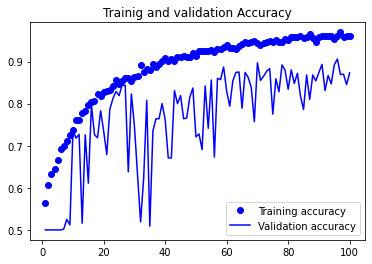

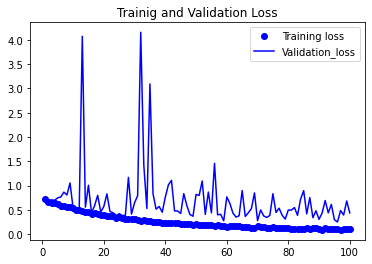

In [ ]:
acc = history.history['accuracy']
val_acc = history.history["val_accuracy"]
loss = history.history['loss']
val_loss = history.history["val_loss"]
epochs =range(1, len(acc)+1)
plt.plot(epochs, acc, "bo", label ="Training accuracy")
plt.plot(epochs, val_acc, 'b', label ="Validation accuracy")
plt.title("Trainig and validation Accuracy")
plt.legend()
plt.figure()

plt.plot(epochs, loss, "bo", label = "Training loss")
plt.plot(epochs, val_loss, 'b', label = "Validation_loss")
plt.title("Trainig and Validation Loss")
plt.legend()
plt.show()

In [ ]:
test_model = keras.models.load_model("residual_depthwise_separable_convolution.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"test accuracy:{test_acc:0.3f}")


63/63 [==============================] - 3s 39ms/step - loss: 0.3059 - accuracy: 0.9020
test accuracy:0.902
